In [4]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt

from numba import njit

# Lattice size
NX = 64
NY = 64
Nspins = NX * NY

# Monte Carlo parameters
ntherm = 1000   # thermalization sweeps per temperature
nsweep = 2000   # measurement sweeps per temperature

print("Parameters:")
print(f"Lattice: {NX} x {NY} spins")
print(f"Thermalization sweeps per T: {ntherm}")
print(f"Measurement sweeps per T:   {nsweep}")


Parameters:
Lattice: 64 x 64 spins
Thermalization sweeps per T: 1000
Measurement sweeps per T:   2000


In [5]:
@njit
def initialize_hot(NX, NY):
    """
    Random initial configuration (+1/-1) for an NX x NY lattice.
    Numba-compatible version.
    """
    spins = np.empty((NX, NY), dtype=np.int8)
    for i in range(NX):
        for j in range(NY):
            if np.random.rand() < 0.5:
                spins[i, j] = 1
            else:
                spins[i, j] = -1
    return spins


@njit
def sweep(spins, beta, h):
    """
    One Metropolis sweep over all sites.
    Periodic boundary conditions, J = 1.
    
    spins: 2D array of +1/-1
    beta = 1/T
    h    = H / (k_B T) (dimensionless field parameter)
    """
    NX, NY = spins.shape
    for i in range(NX):
        ip = (i + 1) % NX
        im = (i - 1) % NX
        for j in range(NY):
            jp = (j + 1) % NY
            jm = (j - 1) % NY

            s = spins[i, j]
            nb = spins[ip, j] + spins[im, j] + spins[i, jp] + spins[i, jm]

            # ΔE = 2 s (nb + H), where H = h / beta (since h = H / (k_B T), beta=1/T)
            H = h / beta
            dE = 2.0 * s * (nb + H)

            # Metropolis acceptance
            if dE <= 0.0 or np.random.rand() < np.exp(-beta * dE):
                spins[i, j] = -s


@njit
def energy(spins, h, T):
    """
    Total energy E of the 2D Ising configuration with:
    - J = 1
    - external field H = h * T  (since h = H / (k_B T), k_B = 1)
    
    Periodic boundary conditions.
    E = - sum_{<ij>} s_i s_j - H sum_i s_i
    We count bonds to the right and up to avoid double-counting.
    """
    NX, NY = spins.shape
    H = h * T
    E = 0.0

    for i in range(NX):
        ip = (i + 1) % NX
        for j in range(NY):
            jp = (j + 1) % NY
            s = spins[i, j]
            E -= s * (spins[ip, j] + spins[i, jp])

    # field term
    M = 0.0
    for i in range(NX):
        for j in range(NY):
            M += spins[i, j]
    E -= H * M

    return E, M



In [6]:
# Temperature range
Tmax = 5.0
Tmin = 0.5
ntemp = 40    # number of temperatures

Ts = np.linspace(Tmax, Tmin, ntemp)

Ms = np.zeros(ntemp)   # magnetization per spin
Es = np.zeros(ntemp)   # energy per spin
Cs = np.zeros(ntemp)   # specific heat per spin

h = 0.0  # external field parameter (use 0.0 for this assignment)

# Seed RNG
np.random.seed(int(time.time()))

# --- warm up Numba (optional but helpful) ---
spins_warmup = initialize_hot(NX, NY)
beta_warm = 1.0 / Tmax
sweep(spins_warmup, beta_warm, h)
E_wu, M_wu = energy(spins_warmup, h, Tmax)
print("Numba warmup done.")

# --- main simulation ---
spins = initialize_hot(NX, NY)

print("Starting 2D Ising simulation with Numba...")
print(f"T from {Tmax} down to {Tmin} in {ntemp} steps.\n")

for idx, T in enumerate(Ts):
    beta = 1.0 / T
    print(f"Simulating T = {T:.3f} (beta = {beta:.3f}) ...")

    # thermalization
    for _ in range(ntherm):
        sweep(spins, beta, h)

    # measurement
    E_sum = 0.0
    E2_sum = 0.0
    M_sum = 0.0

    for _ in range(nsweep):
        sweep(spins, beta, h)
        E_conf, M_conf = energy(spins, h, T)

        E_sum += E_conf
        E2_sum += E_conf * E_conf
        M_sum += M_conf

    # averages (total)
    E_mean_total = E_sum / nsweep
    E2_mean_total = E2_sum / nsweep
    M_mean_total = M_sum / nsweep

    # per spin
    Es[idx] = E_mean_total / Nspins
    Ms[idx] = M_mean_total / Nspins

    # specific heat per spin: C = ( <E^2> - <E>^2 ) / (N T^2)
    Cs[idx] = (E2_mean_total - E_mean_total**2) / (Nspins * T * T)

print("\nSimulation complete.")



Numba warmup done.
Starting 2D Ising simulation with Numba...
T from 5.0 down to 0.5 in 40 steps.

Simulating T = 5.000 (beta = 0.200) ...
Simulating T = 4.885 (beta = 0.205) ...
Simulating T = 4.769 (beta = 0.210) ...
Simulating T = 4.654 (beta = 0.215) ...
Simulating T = 4.538 (beta = 0.220) ...
Simulating T = 4.423 (beta = 0.226) ...
Simulating T = 4.308 (beta = 0.232) ...
Simulating T = 4.192 (beta = 0.239) ...
Simulating T = 4.077 (beta = 0.245) ...
Simulating T = 3.962 (beta = 0.252) ...
Simulating T = 3.846 (beta = 0.260) ...
Simulating T = 3.731 (beta = 0.268) ...
Simulating T = 3.615 (beta = 0.277) ...
Simulating T = 3.500 (beta = 0.286) ...
Simulating T = 3.385 (beta = 0.295) ...
Simulating T = 3.269 (beta = 0.306) ...
Simulating T = 3.154 (beta = 0.317) ...
Simulating T = 3.038 (beta = 0.329) ...
Simulating T = 2.923 (beta = 0.342) ...
Simulating T = 2.808 (beta = 0.356) ...
Simulating T = 2.692 (beta = 0.371) ...
Simulating T = 2.577 (beta = 0.388) ...
Simulating T = 2.462 

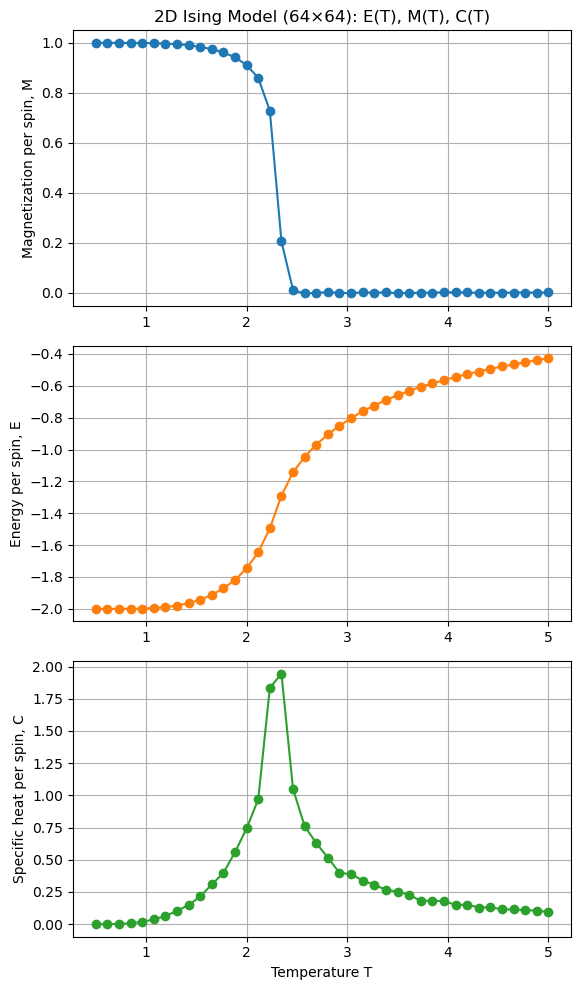

Saved plot as ising.pdf


In [7]:
plt.figure(figsize=(6, 10))

# Magnetization vs T
plt.subplot(3, 1, 1)
plt.plot(Ts, Ms, 'o-', label="M(T)")
plt.ylabel("Magnetization per spin, M")
plt.title("2D Ising Model (64×64): E(T), M(T), C(T)")
plt.grid(True)

# Energy vs T
plt.subplot(3, 1, 2)
plt.plot(Ts, Es, 'o-', label="E(T)", color='tab:orange')
plt.ylabel("Energy per spin, E")
plt.grid(True)

# Specific heat vs T
plt.subplot(3, 1, 3)
plt.plot(Ts, Cs, 'o-', label="C(T)", color='tab:green')
plt.xlabel("Temperature T")
plt.ylabel("Specific heat per spin, C")
plt.grid(True)

plt.tight_layout()
plt.savefig("ising.pdf")
plt.show()

print("Saved plot as ising.pdf")

